In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import time
import copy
import glob
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torchvision.models as models
import torchvision.utils as vutils
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from cnn_finetune import make_model
from PIL import Image
from tqdm import tqdm
import cv2
import albumentations as A
from sklearn.model_selection import KFold
from sklearn import metrics
import math
import pickle
import re
from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose,
    RandomCrop, Normalize, Resize
)
from utils import *

In [2]:
def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def weighted_mse_loss(input, target, weight):
    return torch.mean(torch.mean((input - target) ** 2, dim = -1)*weight)

class custom_MSE_loss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, output, target, angles):
        loss = torch.mean(((1+torch.abs(angles)**1.5)*torch.mean((output - target)**2, axis=1)))
        return loss

class Histogram_loss(torch.nn.Module):
    def __init__(self, K_HL = 5):
        super().__init__()
        self.K_HL = K_HL
        self.sf = nn.Softmax(dim=2)

    def forward(self, output, target):
        loss = -torch.mean(target.reshape(-1,NUM_CLASSES, self.K_HL)*self.sf(output.reshape(-1,NUM_CLASSES, self.K_HL)).log())
        return loss

class L2_SM_loss(torch.nn.Module):
    def __init__(self, K_HL = 5):
        super().__init__()
        self.K_HL = K_HL
        self.sf = nn.Softmax(dim=2)
        
    def forward(self, output, target):
        loss = torch.mean((self.sf(output.reshape(-1,NUM_CLASSES, self.K_HL)) - target.reshape(-1,NUM_CLASSES, self.K_HL))**2)
        return loss

def show(img, size = 8):
    plt.figure(figsize=(size,size))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()
    
def show_VF(data, font_size = 4, size=10):
    count = 0
    VF_map = np.zeros((10,10))
    fig = plt.figure(figsize=(size,size))
    ax = fig.add_subplot(111)
    for i in range(0,10):
        if i < 5:
            k = 3-i
        else:
            k = i-6
        if k < 0:
            k = 0
        for j in range(k,10-k):
            VF_map[i,j] = data[count]
            ax.annotate("{:.2f}".format(data[count]),xy=(j-0.3,i), fontsize=font_size)   
            count += 1                 
    plt.imshow(VF_map)
    plt.show()
    return None

def show_VF_paired(data_GT, data_pred, font_size = 4, size=15):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(size,size))
    show_VF_single(data_GT, ax[0], font_size = font_size)
    ax[0].set_title("Ground truth")
    show_VF_single(data_pred, ax[1], font_size = font_size)
    ax[1].set_title("Prediction")

    plt.show()
    return None

def show_VF_single(data, ax, font_size = 4, size=10, decimal = 1):
    count = 0
    VF_map = np.zeros((10,10))
    VF_map -= 1
    for i in range(0,10):
        if i < 5:
            k = 3-i
        else:
            k = i-6
        if k < 0:
            k = 0
        for j in range(k,10-k):
            VF_map[i,j] = data[count]
            if data[count] < 20:
                ax.annotate(("{:." + str(decimal) + "f}").format(data[count]),xy=(j,i), fontsize=font_size, color='whitesmoke', ha='center')
            else:
                ax.annotate(("{:." + str(decimal) + "f}").format(data[count]),xy=(j,i), fontsize=font_size, color='black', ha='center') 
            count += 1
    ax.imshow(VF_map, vmin=-1, vmax=40, cmap='viridis')
    return None

def show_VF_list(data, list_title = None, font_size = 4, size=15):    
    fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(size,5))
    for i in range(len(data)):
        show_VF_single(data[i], ax[i], font_size = font_size, decimal = 0)
        if list_title is not None:
            ax[i].set_title(list_title[i])
    return fig

In [3]:
class MSE_HD_loss(torch.nn.Module):
    def __init__(self, TH = 0.7):
        super().__init__()
        self.TH = TH

    def convert_vf1d_array2d(self,vf):
        count = 0
        # Use the all zeros array as initial array obtains best performance
        VF_map = np.zeros((vf.shape[0], 10,10))
        for i in range(0,10):
            if i < 5:
                k = 3-i
            else:
                k = i-6
            if k < 0:
                k = 0
            for j in range(k,10-k):
                VF_map[:,i,j] = vf[:,count]
                count += 1
        return VF_map
    
    def convert_vf2d_array1d(self,VF_map):
        count = 0
        vf = np.zeros((VF_map.shape[0],76))
        for i in range(0,10):
            if i < 5:
                k = 3-i
            else:
                k = i-6
            if k < 0:
                k = 0
            for j in range(k,10-k):
                vf[:,count] = VF_map[:,i,j]
                count += 1
        return vf

    def forward(self, output, target):
        output_np = self.convert_vf1d_array2d(output.cpu().detach().numpy())*STD + MEAN
        target_np = self.convert_vf1d_array2d(target.cpu().detach().numpy())*STD + MEAN
        weight = np.zeros((target.shape[0],10,10))
        for i in range(target.shape[0]):
            _, bw = cv2.threshold(target_np[i].astype(np.uint8), 30, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
            _, dist = cv2.threshold(dist, 1, 1,cv2.THRESH_BINARY)
            diff = np.where((target_np[i]-output_np[i]) > 0, 1, 0)
            weight[i] = np.where((1-dist)*diff, self.TH, 1)
        weight = self.convert_vf2d_array1d(weight)
        weight = torch.from_numpy(weight).cuda()
        loss = torch.mean(torch.mean((output - target) ** 2*weight, dim = -1))
        return loss

In [4]:
RND_STATE = 94
NUM_DIM = 10
IMG_SIZE = 224
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
NUM_CLASSES = 76
BATCH_SIZE = 64
NUM_EPOCHS = 25
MEAN = 24.6
STD = 5
K_HL = 10
MAX_VF = 3.88
MIN_VF = -5.12

BORDER_MODE = cv2.BORDER_REFLECT_101
SHIFT_LIMIT = 0.01
SCALE_LIMIT = 0.01
ROTATE_LIMIT = 5
SHIFT_LIMIT_TOMO = 0.01
SCALE_LIMIT_TOMO = 0.01
ROTATE_LIMIT_TOMO = 5
AUG_P = 0.5
HOR_P = 1.

SCALE_H = 1.1
SCALE_W = 1.3

PATH = '/home/quang/working/OCT_images/oct_dataset/'
TH_REG_OUTPUT = 1.5
MODEL_NAME = 'resnet50_1input_regions_MSELoss_'

In [5]:
LIST_COL = []
for i in range(1,77):
    LIST_COL.append('GS_' + str(i))
    
count = 0
LIST_COL_INVERS = []
row_temp = 0
for i in range(0,10):
    if i < 5:
        k = 3-i
    else:
        k = i-6
    if k < 0:
        k = 0
    row_temp = count
    for j in range(2*(5-k),0,-1):
        LIST_COL_INVERS.append('GS_' + str(j+row_temp))
        count += 1

In [6]:
step_size = (MAX_VF-MIN_VF)/K_HL
STD_VF = math.sqrt(step_size/2)
P_DIS = {}
for i in range(-1,45):
    temp_norm_value = (i - MEAN)/STD
    list_pi = []
    Z_temp = 0.5*(math.erf((MAX_VF-temp_norm_value)/(STD_VF*math.sqrt(2))) - math.erf((MIN_VF-temp_norm_value)/(STD_VF*math.sqrt(2))))
    for j in range(K_HL):
        l_i = MIN_VF + j*step_size
        p_j = 0.5*(math.erf((l_i+step_size-temp_norm_value)/(STD_VF*math.sqrt(2))) - math.erf((l_i-temp_norm_value)/(STD_VF*math.sqrt(2))))/Z_temp
        list_pi.append(p_j)
    P_DIS[temp_norm_value] = list_pi
    
LIST_VALUES = []
for j in range(K_HL):
    l_i = MIN_VF + j*step_size
    LIST_VALUES.append(l_i + 0.5*step_size)
LIST_VALUES = torch.tensor(LIST_VALUES).cuda()

## Prepare dataset

In [7]:
df_external = pd.read_csv('/home/quang/working/OCT_images/GOOD_NOTEBOOK/external_data_format/external_data_formated_for_evaluation.csv')
df_external = df_external.astype({'test_date': object})
df_external.test_date = df_external.test_date.astype(str)
df_external['string_path'] = None
df_external['noise'] = 1.

/tmp/ipykernel_24952/51836847.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_external['string_path'] = None
/tmp/ipykernel_24952/51836847.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_external['noise'] = 1.


In [8]:
df_all, df_train, df_test, df_angle = get_dataset_df_all_time()

20443


100%|███████████████████████████████████| 6633/6633 [00:00<00:00, 200860.73it/s]


df_files:  6633
df_files_rnfl:  3591 3591
df_patients : 3367 6633


  0%|                                                  | 0/3367 [00:00<?, ?it/s]/home/quang/working/OCT_images/GOOD_NOTEBOOK/utils.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patients['path_rnfl'][index] = file_path_rnfl
/home/quang/working/OCT_images/GOOD_NOTEBOOK/utils.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patients['path_gcipl'][index] = file_path_gcipl
100%|██████████████████████████████████████| 3367/3367 [00:18<00:00, 180.94it/s]


df_all:  3367
df_train:  2177 1190


In [9]:
df_all['patient_id'].value_counts().mean()

12.47037037037037

In [10]:
len(df_all)

df_all_removed = df_all[(df_all['path_rnfl'] != 'None') & (df_all['path_gcipl'] != 'None')]
len(df_all_removed)

1527

In [11]:
df_all.to_csv('df_all.csv')

In [12]:
g1 = df_all.groupby(['patient_id', 'OD_OS'])
list_id_lr = []
for name, group in g1:
    list_id_lr.append(name)

In [14]:
temp_df = group.sort_values(by=['timeline'])

time_first = temp_df.iloc[0]['timeline']
label_list = []
for index, row in temp_df.iterrows():
    label_list.append(np.array(list(row[LIST_COL])))
    
label_list = np.array(label_list)

In [15]:
df_all['noise'] = 1.
df_all['noise_ae'] = 1.

In [16]:
boolean = not df_all["string_path"].is_unique  

In [17]:
class FundusDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, df_angle, transform=None, transform_flip=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
#         self.df = df
        self.df = df[(df['path_rnfl'] != 'None') & (df['path_gcipl'] != 'None') & (df['string_path'] != 'None')]
        self.df_angle = df_angle
        self.transform = transform
        self.transform_flip = transform_flip
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Read an image with OpenCV
        row = self.df.iloc[idx]
        angle_label_t = self.df_angle[self.df_angle['string_path']==row['string_path']]['angle_od_refined']
        if len(angle_label_t) > 0:
            angle_label = angle_label_t.iloc[0] - 7.264731
        else:
            angle_label = 0
        image_rnfl = cv2.imread(row['path_rnfl'])
        image_rnfl = cv2.cvtColor(image_rnfl, cv2.COLOR_BGR2RGB)
        image = image_rnfl
        if row['OD_OS'] == 'OD':
            if self.transform:
                label = np.array(list(row[LIST_COL]))
                transformed = self.transform(image=image)

        else:            
            if self.transform:
                label = np.array(list(row[LIST_COL_INVERS]))
                transformed = self.transform_flip(image=image)
        
        image = transformed['image']
        label = (label - MEAN)/STD       
        sample = {'image': image, 'label': torch.tensor(label).float(),'string_path': row['string_path'], 'file': row['path_rnfl'], 'angle': torch.tensor(angle_label).float()}
        
        return sample
    
def get_dataloader_noise(df_train, df_test, df_all, df_angle):    
    train_transform = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
    #     A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT, scale_limit=SCALE_LIMIT, rotate_limit=ROTATE_LIMIT, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    #     A.Normalize((0.485, 0.456, 0.406), 0.229, 0.224, 0.225),
        ToTensorV2()
    ])

    train_transform_flip = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT, scale_limit=SCALE_LIMIT, rotate_limit=ROTATE_LIMIT, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    test_transform = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
    #     A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=0, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ])

    test_transform_flip = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=0, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ])

    train_dataset = FundusDataset(df_train, df_angle, transform=train_transform, transform_flip=train_transform_flip)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=16, shuffle=True,
                                                 num_workers=4, drop_last=True)

    test_dataset = FundusDataset(df_test, df_angle, transform=test_transform, transform_flip=test_transform_flip)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=16, shuffle=False,
                                                 num_workers=4)


    test_dataset_all = FundusDataset(df_all, df_angle, transform=test_transform, transform_flip=test_transform_flip)

    test_loader_all = torch.utils.data.DataLoader(test_dataset_all,
                                                 batch_size=16, shuffle=False,
                                                 num_workers=4)

    dataloaders = {'train' : train_loader, 'val' : test_loader}

    dataset_sizes = {'train' : len(train_dataset), 'val' : len(test_dataset)}
    return dataloaders, dataset_sizes, test_loader_all

In [18]:
class OCT_Series_Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, df_angle, transform=None, transform_flip=None,
                transform_tomo=None, transform_flip_tomo=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.df = df
#         self.df = df[(df['path_rnfl'] != 'None') & (df['path_gcipl'] != 'None')]
        self.df_angle = df_angle
        self.transform = transform
        self.transform_flip = transform_flip
        self.transform_tomo = transform_tomo
        self.transform_flip_tomo = transform_flip_tomo
        self.to_tensor = transforms.ToTensor()
        
        g1 = self.df.groupby(['patient_id', 'OD_OS'])
        self.list_id_lr = []
        for name, group in g1:
            temp_df = self.df[(self.df['patient_id'] == name[0]) & (self.df['OD_OS'] == name[1])]
            if len(temp_df) > 1:
                self.list_id_lr.append(name)

    def __len__(self):
        return len(self.list_id_lr)

    def __getitem__(self, idx):
        # Read an image with OpenCV
        temp_df = df_all[(df_all['patient_id'] == self.list_id_lr[idx][0]) & (df_all['OD_OS'] == self.list_id_lr[idx][1])].sort_values(by=['timeline'])
        time_first = temp_df.iloc[0]['timeline']
        if self.list_id_lr[idx][1] == 'OD':
            list_col_temp = LIST_COL
            transform_temp = self.transform
        else:
            list_col_temp = LIST_COL_INVERS
            transform_temp = self.transform_flip

        list_imgs = torch.zeros([0, 3, IMG_SIZE, IMG_SIZE], dtype=torch.float)
        input_list = []
        label_list = []
        total_list = []
        count_temp = 0
        string_paths = []
        list_noise = []
        list_noise_ae = []
#         print (len(temp_df))
        for index, row in temp_df.iterrows():
            data_temp = list(row[list_col_temp])
            data_temp.insert(0, (row['timeline'] - time_first)/12.)
            
            image_rnfl = cv2.imread(row['path_rnfl'])
            image_rnfl = cv2.cvtColor(image_rnfl, cv2.COLOR_BGR2RGB)
            image = image_rnfl
        
            transformed = transform_temp(image=image)
            image = transformed['image']
            if count_temp > 0:
                label_list.append(np.array(data_temp))
            if count_temp < (len(temp_df) - 1):
                input_list.append(np.array(data_temp))
            list_imgs = torch.cat([list_imgs, image.unsqueeze(0)], dim = 0)
            total_list.append(np.array(data_temp))
            string_paths.append(row['string_path'])
            list_noise.append(row['noise'])
            list_noise_ae.append(row['noise_ae'])
            count_temp += 1

        label_list = np.array(label_list).astype(float)
        label_list = (label_list - MEAN)/STD
        
        input_list = np.array(input_list).astype(float)
        input_list = (input_list - MEAN)/STD
        
        total_list = np.array(total_list).astype(float)
        total_list = (total_list - MEAN)/STD
        
        sample = {'input': torch.tensor(input_list).float(), 'label': torch.tensor(label_list[:,1:]).float(), 'imgs': list_imgs,
                  'total_vfs': torch.tensor(total_list[:,1:]).float(), 'string_path': string_paths,
                  'noise': torch.tensor(list_noise).float(), 'noise_ae': torch.tensor(list_noise_ae).float()}
        
        return sample
    
def get_dataloader(df_train, df_test, df_all, df_angle):   
    train_transform_tomo = A.Compose([
        A.Resize(int(IMG_SIZE*SCALE_H), int(IMG_SIZE*SCALE_W)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
    #     A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT, scale_limit=SCALE_LIMIT, rotate_limit=ROTATE_LIMIT, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    #     A.Normalize((0.485, 0.456, 0.406), 0.229, 0.224, 0.225),
        ToTensorV2()
    ])

    train_transform_flip_tomo = A.Compose([
        A.Resize(int(IMG_SIZE*SCALE_H), int(IMG_SIZE*SCALE_W)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT, scale_limit=SCALE_LIMIT, rotate_limit=ROTATE_LIMIT, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    test_transform_tomo = A.Compose([
        A.Resize(int(IMG_SIZE*SCALE_H), int(IMG_SIZE*SCALE_W)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
    #     A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=0, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ])

    test_transform_flip_tomo = A.Compose([
        A.Resize(int(IMG_SIZE*SCALE_H), int(IMG_SIZE*SCALE_W)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=0, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ])

    train_transform = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
    #     A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT, scale_limit=SCALE_LIMIT, rotate_limit=ROTATE_LIMIT, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    #     A.Normalize((0.485, 0.456, 0.406), 0.229, 0.224, 0.225),
        ToTensorV2()
    ])

    train_transform_flip = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT, scale_limit=SCALE_LIMIT, rotate_limit=ROTATE_LIMIT, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    test_transform = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
    #     A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=0, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ])

    test_transform_flip = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=HOR_P),
    #     A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=0, border_mode=BORDER_MODE, value=0, p=1.),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ])

    train_dataset = OCT_Series_Dataset(df_train, df_angle, transform=train_transform, transform_flip=train_transform_flip,
                                 transform_tomo=train_transform_tomo, transform_flip_tomo=train_transform_flip_tomo)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=1, shuffle=True,
                                                 num_workers=1)

    test_dataset = OCT_Series_Dataset(df_test, df_angle, transform=test_transform, transform_flip=test_transform_flip,
                                transform_tomo=test_transform_tomo, transform_flip_tomo=test_transform_flip_tomo)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=1, shuffle=False,
                                                 num_workers=1)


    test_dataset_all = OCT_Series_Dataset(df_all, df_angle, transform=test_transform, transform_flip=test_transform_flip,
                                    transform_tomo=test_transform_tomo, transform_flip_tomo=test_transform_flip_tomo)

    test_loader_all = torch.utils.data.DataLoader(test_dataset_all,
                                                 batch_size=1, shuffle=False,
                                                 num_workers=1)

    dataloaders = {'train' : train_loader, 'val' : test_loader}

    dataset_sizes = {'train' : len(train_dataset), 'val' : len(test_dataset)}
    return dataloaders, dataset_sizes, test_loader_all

In [19]:
class OCT_Series_ver2_Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, df_all, transform=None, transform_flip=None,
                transform_tomo=None, transform_flip_tomo=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.df_all = df_all
        self.transform = transform
        self.transform_flip = transform_flip
        self.transform_tomo = transform_tomo
        self.transform_flip_tomo = transform_flip_tomo
        self.to_tensor = transforms.ToTensor()
        g1 = self.df.groupby(['patient_id', 'OD_OS'])
        self.list_id_lr = []
        for name, group in g1:
            temp_df = self.df[(self.df['patient_id'] == name[0]) & (self.df['OD_OS'] == name[1])]
            if len(temp_df) > 1:
                self.list_id_lr.append(name)

    def __len__(self):
        return len(self.list_id_lr)

    def __getitem__(self, idx):
        # Read an image with OpenCV
        temp_df = self.df_all[(self.df_all['patient_id'] == self.list_id_lr[idx][0]) & (self.df_all['OD_OS'] == self.list_id_lr[idx][1])].sort_values(by=['timeline'])
        time_first = temp_df.iloc[0]['timeline']
        if self.list_id_lr[idx][1] == 'OD':
            list_col_temp = LIST_COL
            transform_temp = self.transform
            transform_vertical = self.transform_tomo
            transform_horizontal = self.transform_tomo
        else:
            list_col_temp = LIST_COL_INVERS
            transform_temp = self.transform_flip
            transform_vertical = self.transform_tomo
            transform_horizontal = self.transform_flip_tomo

        list_imgs = torch.zeros([0, 3, IMG_SIZE, IMG_SIZE], dtype=torch.float)
        list__vertical_imgs = torch.zeros([0, 3, IMG_SIZE, IMG_SIZE], dtype=torch.float)
        list_horizontal_imgs = torch.zeros([0, 3, IMG_SIZE, IMG_SIZE], dtype=torch.float)
        input_list = []
        label_list = []
        total_list = []
        count_temp = 0
        string_paths = []
        list_noise = []
        list_noise_ae = []
        list_timeline = []
        list_intervals = []
        list_file = []
        list_vfi = []
        current_time = time_first
        missing_image = np.zeros((IMG_SIZE,IMG_SIZE,3), dtype=np.uint8)
        for index, row in temp_df.iterrows():
            data_temp = list(row[list_col_temp])
            temp_interval = (row['timeline'] - time_first)/12.
            data_temp.insert(0, temp_interval)
            list_timeline.append((row['timeline'] - time_first)/12.)
#             image_horizontal = cv2.imread(row['path_rnfl'][:-4] + '_horizontalTomo.jpg')
#             image_vertical = cv2.imread(row['path_rnfl'][:-4] + '_verticalTomo.jpg')        
#             image_rnfl = cv2.imread(row['path_rnfl'])
            
#             image_rnfl = cv2.cvtColor(image_rnfl, cv2.COLOR_BGR2RGB)
#             image_vertical = cv2.cvtColor(image_vertical, cv2.COLOR_BGR2RGB)
#             image_horizontal = cv2.cvtColor(image_horizontal, cv2.COLOR_BGR2RGB)
#             image = image_rnfl
            
#             transformed = transform_temp(image=image)
#             image = transformed['image']
            
#             transformed = transform_vertical(image=image_vertical)
#             image_vertical = transformed['image']
            
#             transformed = transform_temp(image=image_horizontal)
#             image_horizontal = transformed['image']
            
            if row['path_rnfl'] == 'None':
                image_rnfl = missing_image.copy()
            else:
                image_rnfl = cv2.imread(row['path_rnfl'])
            image_rnfl = cv2.cvtColor(image_rnfl, cv2.COLOR_BGR2RGB)
            image = image_rnfl
            
#             list_test_date.append(row['test_date'])
            list_file.append(row['path_rnfl'])
            
            try:
                list_vfi.append(re.sub("[^0-9]", "", row['vfi']))
            except  Exception as e:
                print(e)
                print (row['vfi'])
            transformed = transform_temp(image=image)
            image = transformed['image']
            
            if row['path_gcipl'] == 'None':
                image_vertical = missing_image.copy()
                image_horizontal = missing_image.copy()
            else:
                image_horizontal = cv2.imread(row['path_rnfl'][:-4] + '_horizontalTomo.jpg')
                image_vertical = cv2.imread(row['path_rnfl'][:-4] + '_verticalTomo.jpg')        
                image_vertical = cv2.cvtColor(image_vertical, cv2.COLOR_BGR2RGB)
                image_horizontal = cv2.cvtColor(image_horizontal, cv2.COLOR_BGR2RGB)

            transformed = transform_vertical(image=image_vertical)
            image_vertical = transformed['image']

            transformed = transform_temp(image=image_horizontal)
            image_horizontal = transformed['image']
            
            list_file.append(row['path_rnfl'])
            if count_temp > 0:
                label_list.append(np.array(data_temp))
                list_intervals.append((row['timeline'] - current_time)/12.)
                current_time = row['timeline']

            if count_temp < (len(temp_df) - 1):
                input_list.append(np.array(data_temp))
                
            list_imgs = torch.cat([list_imgs, image.unsqueeze(0)], dim = 0)
            list__vertical_imgs = torch.cat([list__vertical_imgs, image_vertical.unsqueeze(0)], dim = 0)
            list_horizontal_imgs = torch.cat([list_horizontal_imgs, image_horizontal.unsqueeze(0)], dim = 0)

            total_list.append(np.array(data_temp))
            if row['string_path'] is None:
                string_paths.append('None')
            else:
                string_paths.append(row['string_path'])
#             string_paths.append(row['string_path'])
            list_noise.append(row['noise'])
            count_temp += 1

        label_list = np.array(label_list).astype(float)
        label_list[:,1:] = (label_list[:,1:] - MEAN)/STD
        
        input_list = np.array(input_list).astype(float)
        input_list[:,1:] = (input_list[:,1:] - MEAN)/STD
        
        total_list = np.array(total_list).astype(float)
        total_list[:,1:] = (total_list[:,1:] - MEAN)/STD

        input_list[:-1,0] = input_list[1:,0]
        input_list[-1,0] = label_list[-1,0]
        
        list_vfi = np.array(list_vfi).astype(float)
        list_vfi = (list_vfi - 80)/10
    
        sample = {'input': torch.tensor(input_list).float(), 'label': torch.tensor(label_list[:,1:]).float(), 'imgs': list_imgs,
                  'total_vfs': torch.tensor(total_list[:,1:]).float(), 'string_path': string_paths,
                  'noise': torch.tensor(list_noise).float(),  'interval': torch.tensor(list_intervals).float(),
                  'timeline': torch.tensor(list_timeline).float(), 'list_file': list_file, 'vertical_imgs': list__vertical_imgs, 
                  'horizontal_imgs': list_horizontal_imgs, 'list_vfi':  torch.tensor(list_vfi[1:]).float()}
        
        return sample

class OCT_Series_ver2_external_Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, df_all, transform=None, transform_flip=None,
                transform_tomo=None, transform_flip_tomo=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.df_all = df_all
        self.transform = transform
        self.transform_flip = transform_flip
        self.transform_tomo = transform_tomo
        self.transform_flip_tomo = transform_flip_tomo
        self.to_tensor = transforms.ToTensor()
        g1 = self.df.groupby(['patient_id', 'OD_OS'])
        self.list_id_lr = []
        for name, group in g1:
            temp_df = self.df[(self.df['patient_id'] == name[0]) & (self.df['OD_OS'] == name[1])]
            if len(temp_df) > 1:
                # name = name + (len(temp_df),)
                self.list_id_lr.append(name)

    def __len__(self):
        return len(self.list_id_lr)

    def __getitem__(self, idx):
        # Read an image with OpenCV
        temp_df = self.df_all[(self.df_all['patient_id'] == self.list_id_lr[idx][0]) & (self.df_all['OD_OS'] == self.list_id_lr[idx][1])].sort_values(by=['timeline'])
        time_first = temp_df.iloc[0]['timeline']
        if self.list_id_lr[idx][1] == 'OD':
            list_col_temp = LIST_COL
            transform_temp = self.transform
            transform_vertical = self.transform_tomo
            transform_horizontal = self.transform_tomo
        else:
            list_col_temp = LIST_COL_INVERS
            transform_temp = self.transform_flip
            transform_vertical = self.transform_tomo
            transform_horizontal = self.transform_flip_tomo
        
        list_imgs = torch.zeros([0, 3, IMG_SIZE, IMG_SIZE], dtype=torch.float)
        list__vertical_imgs = torch.zeros([0, 3, IMG_SIZE, IMG_SIZE], dtype=torch.float)
        list_horizontal_imgs = torch.zeros([0, 3, IMG_SIZE, IMG_SIZE], dtype=torch.float)
        input_list = []
        label_list = []
        total_list = []
        count_temp = 0
        string_paths = []
        list_noise = []
        list_noise_ae = []
        list_timeline = []
        list_intervals = []
        list_file = []
        current_time = time_first
        for index, row in temp_df.iterrows():
            data_temp = list(row[list_col_temp])
            temp_interval = (row['timeline'] - time_first)/12.
            data_temp.insert(0, temp_interval)
            list_timeline.append((row['timeline'] - time_first)/12.)
            image_horizontal = cv2.imread(row['path_rnfl'][:-4] + '_horizontalTomo.jpg')
            image_vertical = cv2.imread(row['path_rnfl'][:-4] + '_verticalTomo.jpg')        
            image_rnfl = cv2.imread(row['path_rnfl'])
            
            image_rnfl = cv2.cvtColor(image_rnfl, cv2.COLOR_BGR2RGB)
            image_vertical = cv2.cvtColor(image_vertical, cv2.COLOR_BGR2RGB)
            image_horizontal = cv2.cvtColor(image_horizontal, cv2.COLOR_BGR2RGB)
            image = image_rnfl
            list_file.append(row['path_rnfl'])
            transformed = transform_temp(image=image)
            image = transformed['image']
            
            transformed = transform_vertical(image=image_vertical)
            image_vertical = transformed['image']
            
            transformed = transform_temp(image=image_horizontal)
            image_horizontal = transformed['image']
            
            if count_temp > 0:
                label_list.append(np.array(data_temp))
                list_intervals.append((row['timeline'] - current_time)/12.)
                current_time = row['timeline']

            if count_temp < (len(temp_df) - 1):
                input_list.append(np.array(data_temp))
                
            list_imgs = torch.cat([list_imgs, image.unsqueeze(0)], dim = 0)
            list__vertical_imgs = torch.cat([list__vertical_imgs, image_vertical.unsqueeze(0)], dim = 0)
            list_horizontal_imgs = torch.cat([list_horizontal_imgs, image_horizontal.unsqueeze(0)], dim = 0)

            total_list.append(np.array(data_temp))
            # string_paths.append(row['string_path'])
            string_paths.append('abc')
            list_noise.append(row['noise'])
            count_temp += 1

        label_list = np.array(label_list).astype(float)
        label_list[:,1:] = (label_list[:,1:] - MEAN)/STD
        
        input_list = np.array(input_list).astype(float)
        input_list[:,1:] = (input_list[:,1:] - MEAN)/STD
        
        total_list = np.array(total_list).astype(float)
        total_list[:,1:] = (total_list[:,1:] - MEAN)/STD

        input_list[:-1,0] = input_list[1:,0]
        input_list[-1,0] = label_list[-1,0]
    
        sample = {'input': torch.tensor(input_list).float(), 'label': torch.tensor(label_list[:,1:]).float(), 'imgs': list_imgs,
                  'total_vfs': torch.tensor(total_list[:,1:]).float(), 'string_path': string_paths,
                  'noise': torch.tensor(list_noise).float(),  'interval': torch.tensor(list_intervals).float(),
                  'timeline': torch.tensor(list_timeline).float(), 'list_file': list_file, 'vertical_imgs': list__vertical_imgs, 
                  'horizontal_imgs': list_horizontal_imgs}
        
        return sample
    
def get_ver2_dataloader(df_train, df_test, df_all):   
    train_transform_tomo = A.Compose([
        A.Resize(int(IMG_SIZE*SCALE_H), int(IMG_SIZE*SCALE_W)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT_TOMO, scale_limit=SCALE_LIMIT_TOMO, rotate_limit=ROTATE_LIMIT_TOMO, border_mode=BORDER_MODE, value=0, p=AUG_P),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    train_transform_flip_tomo = A.Compose([
        A.Resize(int(IMG_SIZE*SCALE_H), int(IMG_SIZE*SCALE_W)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=HOR_P),
        A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT_TOMO, scale_limit=SCALE_LIMIT_TOMO, rotate_limit=ROTATE_LIMIT_TOMO, border_mode=BORDER_MODE, value=0, p=AUG_P),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    test_transform_tomo = A.Compose([
        A.Resize(int(IMG_SIZE*SCALE_H), int(IMG_SIZE*SCALE_W)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=0, border_mode=BORDER_MODE, value=0, p=AUG_P),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ])

    test_transform_flip_tomo = A.Compose([
        A.Resize(int(IMG_SIZE*SCALE_H), int(IMG_SIZE*SCALE_W)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=HOR_P),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=0, border_mode=BORDER_MODE, value=0, p=AUG_P),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ])

    train_transform = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT, scale_limit=SCALE_LIMIT, rotate_limit=ROTATE_LIMIT, border_mode=BORDER_MODE, value=0, p=AUG_P),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    train_transform_flip = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=HOR_P),
        A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT, scale_limit=SCALE_LIMIT, rotate_limit=ROTATE_LIMIT, border_mode=BORDER_MODE, value=0, p=AUG_P),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    test_transform = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=0, border_mode=BORDER_MODE, value=0, p=AUG_P),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ])

    test_transform_flip = A.Compose([
        A.Resize(int(IMG_SIZE*1.1), int(IMG_SIZE*1.1)),
        A.CenterCrop(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=HOR_P),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=0, border_mode=BORDER_MODE, value=0, p=AUG_P),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ])

    train_dataset = OCT_Series_ver2_Dataset(df_train, df_all, 
                                            transform=train_transform, transform_flip=train_transform_flip,
                                            transform_tomo=train_transform_tomo, transform_flip_tomo=train_transform_flip_tomo)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=1, shuffle=True,
                                                 num_workers=4)

    test_dataset = OCT_Series_ver2_Dataset(df_test, df_all,
                                           transform=test_transform, transform_flip=test_transform_flip,
                                           transform_tomo=test_transform_tomo, transform_flip_tomo=test_transform_flip_tomo)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=1, shuffle=False,
                                                 num_workers=4)


    test_dataset_all = OCT_Series_ver2_Dataset(df_all, df_all, 
                                               transform=test_transform, transform_flip=test_transform_flip,
                                               transform_tomo=test_transform_tomo, transform_flip_tomo=test_transform_flip_tomo)

    test_loader_all = torch.utils.data.DataLoader(test_dataset_all,
                                                 batch_size=1, shuffle=False,
                                                 num_workers=4)
    
    test_external_dataset = OCT_Series_ver2_external_Dataset(df_external, df_external,
                                           transform=test_transform, transform_flip=test_transform_flip,
                                           transform_tomo=test_transform_tomo, transform_flip_tomo=test_transform_flip_tomo)

    test_external_loader = torch.utils.data.DataLoader(test_external_dataset,
                                                 batch_size=1, shuffle=False,
                                                 num_workers=4)

    dataloaders = {'train' : train_loader, 'val' : test_loader, 'external': test_external_loader}

    dataset_sizes = {'train' : len(train_dataset), 'val' : len(test_dataset), 'external' : len(test_external_loader)}
    return dataloaders, dataset_sizes, test_loader_all

## Model

In [20]:
def unfreeze(model, ct_c = 7):
    for param in model.parameters():
        param.requires_grad = True

    ct = 0
    for child in model.features[0].children():
        ct += 1
        if ct < ct_c:
            for param in child.parameters():
                param.requires_grad = False

class BoundedGridLocNet(nn.Module):

    def __init__(self, grid_height, grid_width, target_control_points):
        super(BoundedGridLocNet, self).__init__()
        self.cnn = CNN(grid_height * grid_width * 2)

        bias = torch.from_numpy(np.arctanh(target_control_points.numpy()))
        bias = bias.view(-1)
        self.cnn.fc2.bias.data.copy_(bias)
        self.cnn.fc2.weight.data.zero_()

    def forward(self, x):
        batch_size = x.size(0)
        points = F.tanh(self.cnn(x))
        return points.view(batch_size, -1, 2)

class UnBoundedGridLocNet(nn.Module):

    def __init__(self, grid_height, grid_width, target_control_points):
        super(UnBoundedGridLocNet, self).__init__()
        self.cnn = CNN(grid_height * grid_width * 2)

        bias = target_control_points.view(-1)
        self.cnn.fc2.bias.data.copy_(bias)
        self.cnn.fc2.weight.data.zero_()

    def forward(self, x):
        batch_size = x.size(0)
        points = self.cnn(x)
        return points.view(batch_size, -1, 2)

def get_our_model():
    model_K1 = make_model('resnet50', num_classes=NUM_CLASSES, pretrained=True)

    for param in model_K1.parameters():
        param.requires_grad = False

    model_K1._classifier.weight.requires_grad = True
    model_K1._classifier.bias.requires_grad = True

    class Main_Network_ResNet(nn.Module):
        def __init__(self, original_model):
            super(Main_Network_ResNet, self).__init__()
            self.features = nn.Sequential(
                # stop at conv4
                *list(original_model.children())[:-2],
            )

            self.regions = nn.Sequential(nn.AdaptiveAvgPool2d(2),
                        nn.Conv2d(2048, 512, 1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(),
                        nn.Conv2d(512, 128, 1),
                        nn.BatchNorm2d(128),
                        nn.ReLU())
            
            self.regions_ver = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                        nn.Conv2d(2048, 512, 1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(),
                        nn.Conv2d(512, 128, 1),
                        nn.BatchNorm2d(128),
                        nn.ReLU())
            
            self.regions_hor = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                        nn.Conv2d(2048, 512, 1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(),
                        nn.Conv2d(512, 128, 1),
                        nn.BatchNorm2d(128),
                        nn.ReLU())
            
            self.combine = nn.Sequential(nn.Linear(128*2+ 128*4, 128), nn.ReLU())
            
            dim1 = 512
            dim2 = 256
            self.out_ftrs = 256*4

            self.classifier = nn.Sequential(nn.Linear(256 + 76 + 2, 128), nn.ReLU())
            self.dense = nn.Sequential(nn.Linear(128 + 76 + 2, 100), nn.ReLU())
            self.classifier_final = nn.Sequential(nn.Linear(128 + 76 + 2 + 1, 76))
#             self.classifier_final = nn.Sequential(nn.Linear(128 + 2, 76))



            self.lstm_size = 128
            self.lstm = nn.LSTM(128 + 76 + 2 + 1,
                                self.lstm_size,
                                batch_first=True)


        def forward(self, x1, vertical_x1, horizontal_x1, x2, timelines, intervals, noise_list):
            batch_size = x1.size(0)
            
            x1 = self.features(x1)
            x1 = self.regions(x1)
            x1 = x1.view(-1, 128*4)
            
            vertical_x1 = self.features(vertical_x1)
            vertical_x1 = self.regions_ver(vertical_x1)
            vertical_x1 = vertical_x1.view(-1, 128)
        
            horizontal_x1 = self.features(horizontal_x1)
            horizontal_x1 = self.regions_hor(horizontal_x1)
            horizontal_x1 = horizontal_x1.view(-1, 128)
            
            x1 = torch.cat([x1, vertical_x1, horizontal_x1], dim=-1)
            x1 = self.combine(x1)

            x1 = torch.cat([x1, timelines, x2, intervals, noise_list], dim = -1)
            output, state = self.lstm(x1.unsqueeze(0))
            x1 = output[0]
#             print (intervals.shape, timelines.shape, noise_list.shape)
            x1 = torch.cat([x1, x2, intervals, timelines, noise_list], dim=-1)
#             x1 = torch.cat([x1, intervals, timelines], dim=-1)
            
            x1 = self.classifier_final(x1) + x2
            return x1, x1, None

    main_model = Main_Network_ResNet(model_K1)


    model_K = make_model('resnet50', num_classes=NUM_CLASSES, pretrained=True)

    for param in model_K.parameters():
        param.requires_grad = False

    model_K._classifier.weight.requires_grad = True
    model_K._classifier.bias.requires_grad = True


    class Model_Glaucoma(nn.Module):
        def __init__(self, main_net):
            super(Model_Glaucoma, self).__init__()
            self.main_net = main_net
            self.lstm_size = main_net.lstm_size

        def forward(self, thickness_imgs, vertical_imgs, horizontal_imgs, previous_VFs, timelines, intervals, total_VFs, noise_list, prev_state):
            vf_pred, vf_norm, x2_vf_transform_feat = self.main_net(thickness_imgs[0], vertical_imgs[0], horizontal_imgs[0], previous_VFs[0], timelines, intervals, noise_list)
            return vf_pred, vf_norm

        def zero_state(self, batch_size):
            return (torch.zeros(1, batch_size, self.lstm_size),
                    torch.zeros(1, batch_size, self.lstm_size))

    model_all = Model_Glaucoma(main_model)
    return model_all

def get_model():    
    final_model = get_our_model()
    return final_model


def get_model_noise(pre_trained = False, model_name = None):
    model_K = make_model('resnet50', num_classes=NUM_CLASSES, pretrained=True)

    for param in model_K.parameters():
        param.requires_grad = False

    model_K._classifier.weight.requires_grad = True
    model_K._classifier.bias.requires_grad = True


    class InceptionV4Bottom(nn.Module):
                def __init__(self, original_model):
                    super(InceptionV4Bottom, self).__init__()
                    self.features = nn.Sequential(
                        # stop at conv4
                        *list(original_model.children())[:-1]
                    )
                    dim1 = 512
                    dim2 = 256
                    self.num_ftrs = original_model._classifier.in_features    
                    self.classifier = nn.Sequential(nn.Linear(self.num_ftrs, dim2), nn.BatchNorm1d(dim2), nn.ReLU(), # Original model
                                                    nn.Linear(dim2, NUM_CLASSES))

                def forward(self, x1, angle):
                    x1 = self.features(x1)
                    x1 = x1.view(-1, self.num_ftrs)
                    x1 = self.classifier(x1)
                    return x1

    model_ft = InceptionV4Bottom(model_K)
    if pre_trained:
        model_ft.load_state_dict(torch.load(model_name))
    return model_ft

def traing_one_model_noise(dict_pred, model, optimizer, criterion_main, criterion_AE, dataloaders, dataset_sizes,
                     NUM_EPOCHS = 25, training_noise = False, BETA_AE_list = [10, 0.05, 0.001]):
    history = {'train_loss' : [], 'val_loss': [], 'train_main': [], 'val_main': [], 'train_ae': [], 'val_ae': [], 
               'train_acc': [], 'val_acc': [],
               'train_auc': [], 'val_auc': [], 'train_final_score': [], 'val_final_score': []}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 10000
    BETA_AE = BETA_AE_list[0]
    if training_noise:
        for epoch in range(NUM_EPOCHS):
            print('Epoch {}/{}'.format(epoch, NUM_EPOCHS - 1))
            print('-' * 10)
            if epoch == 7:
                BETA_AE = BETA_AE_list[1]
                unfreeze(model, 5)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 0.0001

            if epoch == 15:
                BETA_AE = BETA_AE_list[2]
        #         BETA_AE = 1
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 0.00001  

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                for param_group in optimizer.param_groups:
                    print(param_group['lr'])
                running_loss = 0.0
                running_main = 0
                running_ae = 0

                data_size = dataset_sizes[phase]
                gt_data = np.empty((data_size, NUM_CLASSES), dtype=float)
                pr_data = np.empty((data_size, NUM_CLASSES), dtype=float)
                prMax_data = np.empty((data_size), dtype=float)
                gtMax_data = np.empty((data_size), dtype=float)
                index_C = 0
                # Iterate over data.
                for data_batch_s in tqdm(dataloaders[phase]):
                    inputs = data_batch_s['image']
                    labels = data_batch_s['label'] 
                    angles = data_batch_s['angle']
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    angles = angles.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs, angles)
                        loss_main = criterion_main(outputs, labels.float())
                        loss = loss_main

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_main += loss_main.item() * inputs.size(0)
                    running_ae += loss_main.item() * inputs.size(0)
                    batch_size = inputs.shape[0]

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_main = running_main / dataset_sizes[phase]
                epoch_ae = running_ae / dataset_sizes[phase]


                print('{} Loss: {:.4f}|Main: {:.4f}| AE: {:.4f}'.format(
                    phase, epoch_loss, epoch_main, epoch_ae))
                history[phase + '_loss'].append(epoch_loss)
                history[phase + '_main'].append(epoch_main)
                history[phase + '_ae'].append(epoch_ae)
            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))

        plt.plot(history['train_loss'])
        plt.plot(history['val_loss'])
        plt.title('Total loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.savefig('Aug_loss.png')
        plt.show()

        plt.plot(history['train_main'])
        plt.plot(history['val_main'])
        plt.title('Main loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.savefig('Aug_loss.png')
        plt.show()

        plt.plot(history['train_ae'])
        plt.plot(history['val_ae'])
        plt.title('AE loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.savefig('Aug_loss.png')
        plt.show()
    
    MSE_MAP = 0
    MAE_MAP = 0
    RMSE = 0
    MAE_mean = 0
    LIST_MAE = np.zeros((0))
    list_pred = np.zeros((0,76))
    list_GT = np.zeros((0,76))
    list_file_path = []
    list_string_path = []
    model.eval()
    phase = 'val'
    train_loader_noise = torch.utils.data.DataLoader(dataloaders['train'].dataset,
                                                 batch_size=16, shuffle=False,
                                                 num_workers=4, drop_last=False)
    for data_batch_s in tqdm(train_loader_noise):
        inputs = data_batch_s['image']
        labels = data_batch_s['label'] 
        angles = data_batch_s['angle']
        inputs = inputs.to(device)
        labels = labels.to(device)
        angles = angles.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs, angles)

        labels = labels*STD + MEAN
        outputs = outputs*STD + MEAN

        outputs[outputs > 40] = 40
        outputs[outputs < -1] = -1

        MSE_MAP += torch.sum((labels - outputs)**2, dim=0).detach().cpu().numpy()
        MAE_MAP += torch.sum(torch.abs(labels - outputs), dim=0).detach().cpu().numpy()
        RMSE += np.sqrt(torch.mean((labels - outputs)**2, dim=1).detach().cpu().numpy()).sum()
        MAE_mean += torch.mean(torch.abs(labels - outputs), dim=1).detach().cpu().numpy().sum()
        LIST_MAE = np.append(LIST_MAE, torch.mean(torch.abs(labels - outputs), dim=1).detach().cpu().numpy())
        list_pred = np.append(list_pred, outputs.cpu().numpy(), axis= 0)
        list_GT = np.append(list_GT, labels.cpu().numpy(), axis=0)

        list_file_path.extend(data_batch_s['file'])
        list_string_path.extend(data_batch_s['string_path'])
    MSE_MAP /= dataset_sizes['train']
    MAE_MAP /= dataset_sizes['train']
    RMSE /= dataset_sizes['train']
    MAE_mean /= dataset_sizes['train']
    print('Train result: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(MSE_MAP.mean(), MAE_MAP.mean(), RMSE, MAE_mean))
    
    PATH = './result/baseline/'
    for i in tqdm(range(len(list_GT))):
        id_temp = list_file_path[i].split('/')[-1].split('.')[0].split('_')[0]
        lr_temp = list_file_path[i].split('/')[-1].split('.')[0].split('_')[1]
        dict_pred['file'].append(list_string_path[i])
        dict_pred['vf_GT'].append(list_GT[i])
        dict_pred['vf_pred'].append(list_pred[i])
        
    MSE_MAP = 0
    MAE_MAP = 0
    RMSE = 0
    MAE_mean = 0
    LIST_MAE = np.zeros((0))
    list_pred = np.zeros((0,76))
    list_GT = np.zeros((0,76))
    list_file_path = []
    model.eval()
    for data_batch_s in tqdm(dataloaders['val']):
        inputs = data_batch_s['image']
        labels = data_batch_s['label'] 
        angles = data_batch_s['angle']
        inputs = inputs.to(device)
        labels = labels.to(device)
        angles = angles.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs, angles)

        labels = labels*STD + MEAN
        outputs = outputs*STD + MEAN

        outputs[outputs > 40] = 40
        outputs[outputs < -1] = -1

        MSE_MAP += torch.sum((labels - outputs)**2, dim=0).detach().cpu().numpy()
        MAE_MAP += torch.sum(torch.abs(labels - outputs), dim=0).detach().cpu().numpy()
        RMSE += np.sqrt(torch.mean((labels - outputs)**2, dim=1).detach().cpu().numpy()).sum()
        MAE_mean += torch.mean(torch.abs(labels - outputs), dim=1).detach().cpu().numpy().sum()
        LIST_MAE = np.append(LIST_MAE, torch.mean(torch.abs(labels - outputs), dim=1).detach().cpu().numpy())
        list_pred = np.append(list_pred, outputs.cpu().numpy(), axis= 0)
        list_GT = np.append(list_GT, labels.cpu().numpy(), axis=0)

        list_file_path.extend(data_batch_s['file'])
    MSE_MAP /= dataset_sizes['val']
    MAE_MAP /= dataset_sizes['val']
    RMSE /= dataset_sizes['val']
    MAE_mean /= dataset_sizes['val']
    print('End result: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(MSE_MAP.mean(), MAE_MAP.mean(), RMSE, MAE_mean))

    return MSE_MAP.mean(), MAE_MAP.mean(), RMSE, MAE_mean, model, MSE_MAP, MAE_MAP, dict_pred

def traing_one_model(model, optimizer, criterion_main, criterion_AE, dataloaders, dataset_sizes, 
                     NUM_EPOCHS = 25, BETA_AE_list = [1, 1, 1]):
    history = {'train_loss' : [], 'val_loss': [], 'train_main': [], 'val_main': [], 'train_ae': [], 'val_ae': [], 
               'train_acc': [], 'val_acc': [],
               'train_auc': [], 'val_auc': [], 'train_final_score': [], 'val_final_score': []}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 10000
    BETA_AE = BETA_AE_list[0]
    mse_hd = MSE_HD_loss(0.7)
    for epoch in range(NUM_EPOCHS):
        print('Epoch {}/{}'.format(epoch, NUM_EPOCHS - 1))
        print('-' * 10)
        if epoch == 7:
            BETA_AE = BETA_AE_list[1]
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.0001

        if epoch == 15:
            BETA_AE = BETA_AE_list[2]
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.00001  

        
        state_h, state_c = model.zero_state(1)
        
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for param_group in optimizer.param_groups:
                print(param_group['lr'])
            
            running_loss = 0.0
            running_main = 0
            running_ae = 0

            data_size = dataset_sizes[phase]
            gt_data = np.empty((data_size, NUM_CLASSES), dtype=float)
            pr_data = np.empty((data_size, NUM_CLASSES), dtype=float)
            prMax_data = np.empty((data_size), dtype=float)
            gtMax_data = np.empty((data_size), dtype=float)
            index_C = 0
            for data_batch_s in tqdm(dataloaders[phase]):
                previous_VFs = data_batch_s['input']
                labels = data_batch_s['label']
                imgs_data = data_batch_s['imgs']
                vertical_imgs_data = data_batch_s['vertical_imgs']
                horizontal_imgs_data = data_batch_s['horizontal_imgs']
                noise_list = data_batch_s['noise']
                timelines = data_batch_s['timeline']
                intervals = data_batch_s['interval']
                total_VFs = data_batch_s['total_vfs'][:,0,:]
                if phase == 'train' and  previous_VFs.shape[1] < 2:
                    continue
                if previous_VFs.shape[1] == 0 or labels.shape[1] == 0:
                    continue
                previous_VFs = previous_VFs.to(device)
                labels = labels.to(device)
                imgs_data = imgs_data.to(device)[:,:-1]
                vertical_imgs_data = vertical_imgs_data.to(device)[:,:-1]
                horizontal_imgs_data = horizontal_imgs_data.to(device)[:,:-1]
                noise_list = noise_list.to(device)
                total_VFs = total_VFs.to(device)
                intervals = intervals.to(device).reshape(-1,1)
                timelines = timelines.to(device)[0, 1:].unsqueeze(-1)
                
                batch_size_c = noise_list.shape[1] - 1
                noise_list = noise_list.view(batch_size_c + 1)
                optimizer.zero_grad()
                
                batch_size = labels.shape[1]
                with torch.set_grad_enabled(phase == 'train'):
                    mask = noise_list.reshape(-1,1)[:-1]
                    outputs, vf_norm = model(imgs_data, vertical_imgs_data, horizontal_imgs_data, previous_VFs[:,:,1:], timelines, intervals, total_VFs, mask, (state_h, state_c))
                    vf_preds = noise_list[1:]
                    loss_ae = torch.tensor(0)
                    y = torch.ones(labels.shape[1]) * TH_REG_OUTPUT 
                    y = y.cuda()
                    outputs = outputs.view(batch_size_c, 76)
                    labels = labels.view(batch_size_c, 76)
                    
                    loss_main = weighted_mse_loss(outputs, labels.float(), torch.exp(TH_REG_OUTPUT - torch.where(vf_preds > TH_REG_OUTPUT, vf_preds, y)))
                    loss_norm_cnn =  weighted_mse_loss(vf_norm, labels.float(), torch.exp(TH_REG_OUTPUT - torch.where(vf_preds > TH_REG_OUTPUT, vf_preds, y)))
                    loss_hd = mse_hd(outputs, labels.float())
                    loss = 1.*loss_main + 1.7*loss_hd
                    state_h = state_h.detach()
                    state_c = state_c.detach()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * previous_VFs.size(1)
                running_main += loss_main.item() * previous_VFs.size(1)
                running_ae += loss_ae.item() * previous_VFs.size(1)
                batch_size = previous_VFs.shape[1]

                state_msg = ('Loss: {:.4f}'.format(loss_main.item()))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_main = running_main / dataset_sizes[phase]
            epoch_ae = running_ae / dataset_sizes[phase]


            print('{} Loss: {:.4f}|Main: {:.4f}| AE: {:.4f}'.format(
                phase, epoch_loss, epoch_main, epoch_ae))
            history[phase + '_loss'].append(epoch_loss)
            history[phase + '_main'].append(epoch_main)
            history[phase + '_ae'].append(epoch_ae)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Total loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('Aug_loss.png')
    plt.show()

    plt.plot(history['train_main'])
    plt.plot(history['val_main'])
    plt.title('Main loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('Aug_loss.png')
    plt.show()

    plt.plot(history['train_ae'])
    plt.plot(history['val_ae'])
    plt.title('AE loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('Aug_loss.png')
    plt.show()
    
#     MSE_MAP = 0
#     MAE_MAP = 0
#     RMSE = 0
#     MAE_mean = 0
#     LIST_MAE = np.zeros((0))
#     list_pred = np.zeros((0,76))
#     list_GT = np.zeros((0,76))
#     LIST_INTERVALS = np.zeros((0))
#     LIST_VISITS = np.zeros((0))
#     list_file_path = []
#     m_sf = nn.Softmax(dim=2)
#     num_of_samples = 0
#     for data_batch_s in tqdm(dataloaders['val']):
#         previous_VFs = data_batch_s['input']
#         labels = data_batch_s['label']
#         imgs_data = data_batch_s['imgs']
#         vertical_imgs_data = data_batch_s['vertical_imgs']
#         horizontal_imgs_data = data_batch_s['horizontal_imgs']
#         noise_list = data_batch_s['noise']
#         timelines = data_batch_s['timeline']
#         intervals = data_batch_s['interval']
#         total_VFs = data_batch_s['total_vfs'][:,0,:]
#         if phase == 'train' and  previous_VFs.shape[1] < 2:
#             continue
#         if previous_VFs.shape[1] == 0 or labels.shape[1] == 0:
#             continue
#         previous_VFs = previous_VFs.to(device)
#         labels = labels.to(device)
#         imgs_data = imgs_data.to(device)[:,:-1]
#         vertical_imgs_data = vertical_imgs_data.to(device)[:,:-1]
#         horizontal_imgs_data = horizontal_imgs_data.to(device)[:,:-1]
#         noise_list = noise_list.to(device)
#         total_VFs = total_VFs.to(device)
#         intervals = intervals.to(device).reshape(-1,1)
#         timelines = timelines.to(device)[0, 1:].unsqueeze(-1)
        
#         batch_size_c = noise_list.shape[1] - 1
#         noise_list = noise_list.view(batch_size_c + 1)

#         optimizer.zero_grad()

#         with torch.set_grad_enabled(phase == 'train'):
#             mask = noise_list.reshape(-1,1)[:-1]
#             outputs, vf_norm = model(imgs_data, vertical_imgs_data, horizontal_imgs_data, previous_VFs[:,:,1:], timelines, intervals, total_VFs, mask, (state_h, state_c))


#         labels = labels*STD + MEAN
#         outputs = outputs*STD + MEAN
        
#         outputs = outputs.view(-1, 76)
#         labels = labels.view(-1, 76)
        
#         num_of_samples += outputs.shape[0]

#         outputs[outputs > 40] = 40
#         outputs[outputs < -1] = -1

#         MSE_MAP += torch.sum((labels - outputs)**2, dim=0).detach().cpu().numpy()
#         MAE_MAP += torch.sum(torch.abs(labels - outputs), dim=0).detach().cpu().numpy()
#         RMSE += np.sqrt(torch.mean((labels - outputs)**2, dim=1).detach().cpu().numpy()).sum()
#         MAE_mean += torch.mean(torch.abs(labels - outputs), dim=1).detach().cpu().numpy().sum()
#         LIST_MAE = np.append(LIST_MAE, torch.mean(torch.abs(labels - outputs), dim=1).detach().cpu().numpy())
#         list_pred = np.append(list_pred, outputs.cpu().numpy(), axis= 0)
#         list_GT = np.append(list_GT, labels.cpu().numpy(), axis=0)
#         LIST_INTERVALS = np.append(LIST_INTERVALS, intervals.cpu().numpy().reshape(-1), axis=0)
#         LIST_VISITS = np.append(LIST_VISITS, np.arange(1,intervals.shape[0]+1), axis=0)
#         list_file_path.extend(data_batch_s['string_path'])
#     MSE_MAP /= num_of_samples
#     MAE_MAP /= num_of_samples
#     RMSE /= num_of_samples
#     MAE_mean /= num_of_samples
#     print('End result: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(MSE_MAP.mean(), MAE_MAP.mean(), RMSE, MAE_mean))
#     data_one_fold = {'file':list_file_path, 'GT': list_GT, 'pred': list_pred, 'interval': LIST_INTERVALS, 'visits': LIST_VISITS}  
#     return MSE_MAP.mean(), MAE_MAP.mean(), RMSE, MAE_mean, model, MSE_MAP, MAE_MAP, data_one_fold

    MSE_MAP = 0
    MAE_MAP = 0
    RMSE = 0
    MAE_mean = 0
    LIST_MAE = np.zeros((0))
    list_pred = np.zeros((0,76))
    list_GT = np.zeros((0,76))
    LIST_INTERVALS = np.zeros((0))
    LIST_VISITS = np.zeros((0))
    list_file_path = []
    m_sf = nn.Softmax(dim=2)
    num_of_samples = 0
    for data_batch_s in tqdm(dataloaders['val']):
        previous_VFs = data_batch_s['input']
        labels = data_batch_s['label']
        imgs_data = data_batch_s['imgs']
        vertical_imgs_data = data_batch_s['vertical_imgs']
        horizontal_imgs_data = data_batch_s['horizontal_imgs']
        noise_list = data_batch_s['noise']
        timelines = data_batch_s['timeline']
        intervals = data_batch_s['interval']
        total_VFs = data_batch_s['total_vfs'][:,0,:]
        if phase == 'train' and  previous_VFs.shape[1] < 2:
            continue
        if previous_VFs.shape[1] == 0 or labels.shape[1] == 0:
            continue
        previous_VFs = previous_VFs.to(device)
        labels = labels.to(device)
        imgs_data = imgs_data.to(device)[:,:-1]
        vertical_imgs_data = vertical_imgs_data.to(device)[:,:-1]
        horizontal_imgs_data = horizontal_imgs_data.to(device)[:,:-1]
        noise_list = noise_list.to(device)
        total_VFs = total_VFs.to(device)
        intervals = intervals.to(device).reshape(-1,1)
        timelines = timelines.to(device)[0, 1:].unsqueeze(-1)
        
        batch_size_c = noise_list.shape[1] - 1
        noise_list = noise_list.view(batch_size_c + 1)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            mask = noise_list.reshape(-1,1)[:-1]
            outputs, vf_norm = model(imgs_data, vertical_imgs_data, horizontal_imgs_data, previous_VFs[:,:,1:], timelines, intervals, total_VFs, mask, (state_h, state_c))

        labels = labels*STD + MEAN
        outputs = outputs*STD + MEAN
        
        outputs = outputs.view(-1, 76)
        labels = labels.view(-1, 76)
        
        num_of_samples += outputs.shape[0]

        outputs[outputs > 40] = 40
        outputs[outputs < -1] = -1

        MSE_MAP += torch.sum((labels - outputs)**2, dim=0).detach().cpu().numpy()
        MAE_MAP += torch.sum(torch.abs(labels - outputs), dim=0).detach().cpu().numpy()
        RMSE += np.sqrt(torch.mean((labels - outputs)**2, dim=1).detach().cpu().numpy()).sum()
        MAE_mean += torch.mean(torch.abs(labels - outputs), dim=1).detach().cpu().numpy().sum()
        LIST_MAE = np.append(LIST_MAE, torch.mean(torch.abs(labels - outputs), dim=1).detach().cpu().numpy())
        list_pred = np.append(list_pred, outputs.cpu().numpy(), axis= 0)
        list_GT = np.append(list_GT, labels.cpu().numpy(), axis=0)
        LIST_INTERVALS = np.append(LIST_INTERVALS, intervals.cpu().numpy().reshape(-1), axis=0)
        LIST_VISITS = np.append(LIST_VISITS, np.arange(1,intervals.shape[0]+1), axis=0)
        list_file_path.extend(data_batch_s['string_path'][1:])
    MSE_MAP /= num_of_samples
    MAE_MAP /= num_of_samples
    RMSE /= num_of_samples
    MAE_mean /= num_of_samples
    print('Validation End result: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(MSE_MAP.mean(), MAE_MAP.mean(), RMSE, MAE_mean))
    data_one_fold = {'file':list_file_path, 'GT': list_GT, 'pred': list_pred, 'interval': LIST_INTERVALS, 'visits': LIST_VISITS} 
    
    MSE_MAP_external = 0
    MAE_MAP_external = 0
    RMSE_external = 0
    MAE_mean_external = 0
    LIST_MAE_external = np.zeros((0))
    list_pred_external = np.zeros((0,76))
    list_GT_external = np.zeros((0,76))
    LIST_INTERVALS_external = np.zeros((0))
    LIST_VISITS_external = np.zeros((0))
    list_file_path_external = []
    m_sf = nn.Softmax(dim=2)
    num_of_samples_external = 0
    for data_batch_s in tqdm(dataloaders['external']):
        previous_VFs = data_batch_s['input']
        labels = data_batch_s['label']
        imgs_data = data_batch_s['imgs']
        vertical_imgs_data = data_batch_s['vertical_imgs']
        horizontal_imgs_data = data_batch_s['horizontal_imgs']
        noise_list = data_batch_s['noise']
        timelines = data_batch_s['timeline']
        intervals = data_batch_s['interval']
        total_VFs = data_batch_s['total_vfs'][:,0,:]
        if phase == 'train' and  previous_VFs.shape[1] < 2:
            continue
        if previous_VFs.shape[1] == 0 or labels.shape[1] == 0:
            continue
        previous_VFs = previous_VFs.to(device)
        labels = labels.to(device)
        imgs_data = imgs_data.to(device)[:,:-1]
        vertical_imgs_data = vertical_imgs_data.to(device)[:,:-1]
        horizontal_imgs_data = horizontal_imgs_data.to(device)[:,:-1]
        noise_list = noise_list.to(device)
        total_VFs = total_VFs.to(device)
        intervals = intervals.to(device).reshape(-1,1)
        timelines = timelines.to(device)[0, 1:].unsqueeze(-1)
        
        batch_size_c = noise_list.shape[1] - 1
        noise_list = noise_list.view(batch_size_c + 1)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            mask = noise_list.reshape(-1,1)[:-1]
            outputs, vf_norm = model(imgs_data, vertical_imgs_data, horizontal_imgs_data, previous_VFs[:,:,1:], timelines, intervals, total_VFs, mask, (state_h, state_c))


        labels = labels*STD + MEAN
        outputs = outputs*STD + MEAN
        
        outputs = outputs.view(-1, 76)
        labels = labels.view(-1, 76)
        
        num_of_samples_external += outputs.shape[0]

        outputs[outputs > 40] = 40
        outputs[outputs < -1] = -1

        MSE_MAP_external += torch.sum((labels - outputs)**2, dim=0).detach().cpu().numpy()
        MAE_MAP_external += torch.sum(torch.abs(labels - outputs), dim=0).detach().cpu().numpy()
        RMSE_external += np.sqrt(torch.mean((labels - outputs)**2, dim=1).detach().cpu().numpy()).sum()
        MAE_mean_external += torch.mean(torch.abs(labels - outputs), dim=1).detach().cpu().numpy().sum()
        LIST_MAE_external = np.append(LIST_MAE_external, torch.mean(torch.abs(labels - outputs), dim=1).detach().cpu().numpy())
        list_pred_external = np.append(list_pred_external, outputs.cpu().numpy(), axis= 0)
        list_GT_external = np.append(list_GT_external, labels.cpu().numpy(), axis=0)
        LIST_INTERVALS_external = np.append(LIST_INTERVALS_external, intervals.cpu().numpy().reshape(-1), axis=0)
        LIST_VISITS_external = np.append(LIST_VISITS_external, np.arange(1,intervals.shape[0]+1), axis=0)
        list_file_path_external.extend(data_batch_s['string_path'][1:])
    MSE_MAP_external /= num_of_samples_external
    MAE_MAP_external /= num_of_samples_external
    RMSE_external /= num_of_samples_external
    MAE_mean_external /= num_of_samples_external
    print('External End result: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(MSE_MAP_external.mean(), MAE_MAP_external.mean(), RMSE_external, MAE_mean_external))

    data_one_fold_external = {'file':list_file_path_external, 'GT': list_GT_external, 'pred': list_pred_external, 'interval': LIST_INTERVALS_external, 'visits': LIST_VISITS_external}
    return MSE_MAP.mean(), MAE_MAP.mean(), RMSE, MAE_mean, MSE_MAP_external.mean(), MAE_MAP_external.mean(), RMSE_external, MAE_mean_external, model, MSE_MAP, MAE_MAP, data_one_fold, data_one_fold_external


def update_noise(df_all, dict_pred, test_loader_train_noise):
    df_all['noise'] = -1.
    dict_vfs = {}
    dict_ae_GT = {}
    dict_ae_pred = {}
    dict_encoding_pred = {}
    for data_batch_s in tqdm(test_loader_train_noise):
        inputs = data_batch_s['input']
        labels = data_batch_s['label']
        total_vfs = data_batch_s['total_vfs']
        if inputs.shape[1] == 0 or labels.shape[1] == 0:
            continue
        list_str_path_valid = []
        vf_preds = []
        for t in data_batch_s['string_path']:
            if t[0] != 'None':
                vf_preds.append(dict_pred['vf_pred'][dict_pred['file'].index(t[0])])
                list_str_path_valid.append(t)
#             vf_preds.append(dict_pred['vf_pred'][dict_pred['file'].index(t[0])])
        vf_preds = np.array(vf_preds)

        vf_GT = []
        for t in data_batch_s['string_path']:
            if t[0] != 'None':
                vf_GT.append(dict_pred['vf_GT'][dict_pred['file'].index(t[0])])
#             vf_GT.append(dict_pred['vf_GT'][dict_pred['file'].index(t[0])])
        vf_GT = np.array(vf_GT)
        with torch.set_grad_enabled(False):
            diff_vfs = np.mean(np.abs(vf_preds-vf_GT), axis=-1)
            diff_vfs = diff_vfs - diff_vfs.min()
            if diff_vfs.mean() < 0.001:
                label_noise = np.ones_like(diff_vfs)
            else:
                diff_vfs = diff_vfs/diff_vfs.mean()
                label_noise = diff_vfs

        if len(list_str_path_valid) == 0:
            continue
        for i in range(label_noise.shape[0]):
            df_all.loc[df_all['string_path'] == list_str_path_valid[i][0], 'noise'] = label_noise[i]

    return df_all

def training_cross_val(df_all, n_KFold = 5, NUM_EPOCHS = 25, training_noise = False):
    lista = []
    listb = []
    listc = []
    listd = []
    lista_external = []
    listb_external = []
    listc_external = []
    listd_external = []
    i = 0
    kf = KFold(n_splits=n_KFold, random_state=14, shuffle=True)
    ids_all = df_all['patient_id'].unique()
    fold_c = 0
    results_all = {}
    results_all_external = {}
    for train_index, test_index in kf.split(ids_all):
        df_train = df_all.loc[df_all['patient_id'].isin(ids_all[train_index])]
        df_test = df_all.loc[df_all['patient_id'].isin(ids_all[test_index])]

        df_train = df_train.reset_index(drop=True)
        df_test = df_test.reset_index(drop=True)

        print (len(df_train), len(df_test))
        
        dict_pred = {'file': [], 'vf_GT': [], 'vf_pred': []}
        dataloaders_noise, dataset_sizes_noise, _ = get_dataloader_noise(df_train, df_test, df_all, df_angle)
        
        print ('EXP #{}'.format(i))
        if training_noise is False:
            model = get_model_noise(pre_trained = True, model_name = MODEL_NAME + str(fold_c) + '_ver2.pt')
        else:
            model = get_model_noise()        

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(device)

        model = model.to(device)
        criterion_AE = nn.MSELoss()
        criterion_main = nn.MSELoss()

        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)

        if training_noise:
            a,b,c,d, model, MSE_MAP, MAE_MAP, dict_pred = traing_one_model_noise(dict_pred, model, optimizer, criterion_main, criterion_AE, dataloaders_noise, dataset_sizes_noise,
                                                                NUM_EPOCHS = 5, training_noise = training_noise)
            torch.save(model.state_dict(), MODEL_NAME + str(fold_c) + '_ver3.pt')
        else:
            a,b,c,d, model, MSE_MAP, MAE_MAP, dict_pred = traing_one_model_noise(dict_pred, model, optimizer, criterion_main, criterion_AE, dataloaders_noise, dataset_sizes_noise,
                                                                NUM_EPOCHS = 25, training_noise = training_noise)
        
        #===================================================
        
        dataloaders, dataset_sizes, _ = get_ver2_dataloader(df_train, df_test, df_all)
        df_all = update_noise(df_all, dict_pred, dataloaders['train'])
        dataloaders, dataset_sizes, _ = get_ver2_dataloader(df_train, df_test, df_all)

        print ('EXP #{}'.format(i))
        model = get_model()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(device)

        model = model.to(device)

        criterion_AE = nn.MSELoss()
        criterion_main = nn.MSELoss()   

        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

        a,b,c,d, a_external,b_external,c_external,d_external, model, MSE_MAP, MAE_MAP, data_one_fold, data_one_fold_external = traing_one_model(model, optimizer, criterion_main, criterion_AE,
                                                             dataloaders, dataset_sizes, NUM_EPOCHS = NUM_EPOCHS)
        
        results_all[fold_c] = data_one_fold
        results_all_external[fold_c] = data_one_fold_external
        fold_c += 1
        lista.append(a)
        listb.append(b)
        listc.append(c)
        listd.append(d)
        
        lista_external.append(a_external)
        listb_external.append(b_external)
        listc_external.append(c_external)
        listd_external.append(d_external)
        i += 1
        
    save_obj(results_all, 'MICCAIworkshop_model_refactor.pkl')
    save_obj(results_all_external, 'MICCAIworkshop_model_refactor_external.pkl')
    show_VF(MSE_MAP, 9, 7)
    show_VF(MAE_MAP, 11, 7)
    print ('='*15)
    print('OVERALL: MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}'.format(np.array(lista).mean(), np.array(listb).mean(), np.array(listc).mean(), np.array(listd).mean()))
    print('External OVERALL: MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}'.format(np.array(lista_external).mean(), np.array(listb_external).mean(), np.array(listc_external).mean(), np.array(listd_external).mean()))
    return model, dataloaders

## Training

In [23]:
dataloaders, dataset_sizes, test_loader_all = get_ver2_dataloader(df_train, df_test, df_all)

In [25]:
TH_REG_OUTPUT = 1.5

2653 714
EXP #0
cuda:0


100%|███████████████████████████████████████████| 75/75 [00:03<00:00, 24.33it/s]


Train result: 20.2319, 2.9162, 4.0572, 2.9162


100%|███████████████████████████████████████████| 21/21 [00:01<00:00, 20.52it/s]


End result: 30.6621, 3.6427, 4.9255, 3.6427


 51%|█████████████████████                    | 111/216 [00:05<00:03, 27.98it/s]/home/quang/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/quang/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 53%|█████████████████████▊                   | 115/216 [00:05<00:05, 19.52it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:10<00:00, 20.68it/s]


EXP #0
cuda:0
Epoch 0/14
----------
0.001


 86%|███████████████████████████████████▎     | 186/216 [00:15<00:02, 13.55it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.83it/s]


train Loss: 32.9169|Main: 12.3906| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.56it/s]


val Loss: 33.7296|Main: 13.2501| AE: 0.0000

Epoch 1/14
----------
0.001


 85%|██████████████████████████████████▋      | 183/216 [00:15<00:02, 11.68it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.68it/s]


train Loss: 29.2695|Main: 10.9798| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.39it/s]


val Loss: 31.3291|Main: 12.2765| AE: 0.0000

Epoch 2/14
----------
0.001


 71%|█████████████████████████████▏           | 154/216 [00:13<00:04, 12.63it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.68it/s]


train Loss: 28.0518|Main: 10.5025| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.53it/s]


val Loss: 31.0790|Main: 12.2403| AE: 0.0000

Epoch 3/14
----------
0.001


 83%|█████████████████████████████████▉       | 179/216 [00:15<00:02, 12.89it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.59it/s]


train Loss: 27.1313|Main: 10.1549| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.49it/s]


val Loss: 30.6655|Main: 12.0959| AE: 0.0000

Epoch 4/14
----------
0.001


  0%|                                                   | 0/216 [00:00<?, ?it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.34it/s]


train Loss: 26.3743|Main: 9.8595| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.37it/s]


val Loss: 31.7063|Main: 12.4973| AE: 0.0000

Epoch 5/14
----------
0.001


 16%|██████▊                                   | 35/216 [00:03<00:15, 11.93it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.40it/s]


train Loss: 25.8857|Main: 9.6776| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.48it/s]


val Loss: 28.9641|Main: 11.4101| AE: 0.0000

Epoch 6/14
----------
0.001


  4%|█▊                                         | 9/216 [00:01<00:23,  8.71it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.43it/s]


train Loss: 25.4074|Main: 9.5003| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.27it/s]


val Loss: 28.2902|Main: 11.0450| AE: 0.0000

Epoch 7/14
----------
0.0001


  7%|██▉                                       | 15/216 [00:01<00:17, 11.32it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.29it/s]


train Loss: 24.4676|Main: 9.1238| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.13it/s]


val Loss: 27.8938|Main: 10.9215| AE: 0.0000

Epoch 8/14
----------
0.0001


 25%|██████████▎                               | 53/216 [00:05<00:13, 11.65it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.09it/s]


train Loss: 24.3027|Main: 9.0748| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.15it/s]


val Loss: 27.9046|Main: 10.9307| AE: 0.0000

Epoch 9/14
----------
0.0001


  8%|███▌                                      | 18/216 [00:02<00:23,  8.27it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.43it/s]


train Loss: 24.2307|Main: 9.0493| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.02it/s]


val Loss: 27.7973|Main: 10.8852| AE: 0.0000

Epoch 10/14
----------
0.0001


 34%|██████████████▏                           | 73/216 [00:07<00:12, 11.29it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.27it/s]


train Loss: 24.1768|Main: 9.0267| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.02it/s]


val Loss: 27.7334|Main: 10.8590| AE: 0.0000

Epoch 11/14
----------
0.0001


 39%|████████████████▌                         | 85/216 [00:07<00:10, 12.27it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.34it/s]


train Loss: 24.1127|Main: 9.0067| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.31it/s]


val Loss: 27.6779|Main: 10.8315| AE: 0.0000

Epoch 12/14
----------
0.0001


 10%|████▎                                     | 22/216 [00:02<00:19, 10.12it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.36it/s]


train Loss: 24.0469|Main: 8.9740| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.26it/s]


val Loss: 27.6369|Main: 10.8251| AE: 0.0000

Epoch 13/14
----------
0.0001


 50%|████████████████████▋                    | 109/216 [00:09<00:09, 11.27it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.25it/s]


train Loss: 24.0032|Main: 8.9651| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.60it/s]


val Loss: 27.6381|Main: 10.8350| AE: 0.0000

Epoch 14/14
----------
0.0001


 10%|████                                      | 21/216 [00:02<00:15, 12.44it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.26it/s]


train Loss: 23.9492|Main: 8.9451| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.22it/s]


val Loss: 27.6259|Main: 10.8376| AE: 0.0000

Training complete in 5m 56s


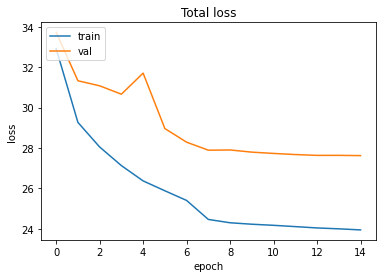

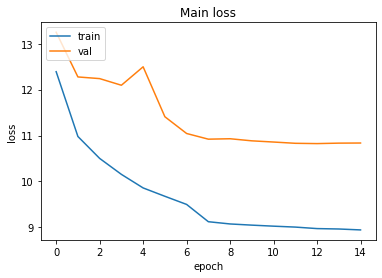

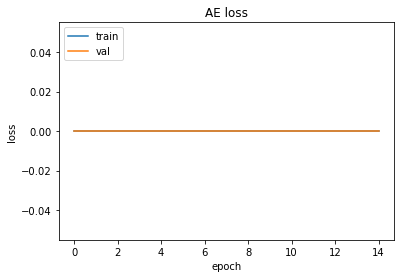

100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.06it/s]


Validation End result: 22.0567, 3.0872, 4.3944, 3.0872


100%|███████████████████████████████████████████| 89/89 [00:03<00:00, 24.93it/s]


External End result: 32.9981, 3.5034, 5.1818, 3.5034
2698 669
EXP #1
cuda:0


100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 28.47it/s]


Train result: 19.4425, 2.8961, 3.9961, 2.8961


100%|███████████████████████████████████████████| 19/19 [00:01<00:00, 18.16it/s]


End result: 29.0937, 3.5987, 4.8693, 3.5987


  0%|                                                   | 0/216 [00:00<?, ?it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:10<00:00, 21.40it/s]


EXP #1
cuda:0
Epoch 0/14
----------
0.001


 91%|█████████████████████████████████████▍   | 197/216 [00:17<00:01, 11.85it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.39it/s]


train Loss: 32.6062|Main: 12.2566| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.24it/s]


val Loss: 33.9365|Main: 13.2490| AE: 0.0000

Epoch 1/14
----------
0.001


 79%|████████████████████████████████▍        | 171/216 [00:15<00:03, 12.37it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.22it/s]


train Loss: 29.0697|Main: 10.9067| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.20it/s]


val Loss: 32.3203|Main: 12.6294| AE: 0.0000

Epoch 2/14
----------
0.001


 63%|█████████████████████████▊               | 136/216 [00:12<00:07, 11.32it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.17it/s]


train Loss: 27.7717|Main: 10.4163| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.08it/s]


val Loss: 31.0025|Main: 12.1101| AE: 0.0000

Epoch 3/14
----------
0.001


 70%|████████████████████████████▊            | 152/216 [00:13<00:05, 12.09it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.20it/s]


train Loss: 26.7859|Main: 10.0258| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.96it/s]


val Loss: 30.9621|Main: 12.1054| AE: 0.0000

Epoch 4/14
----------
0.001


 88%|████████████████████████████████████     | 190/216 [00:16<00:02, 11.82it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.39it/s]


train Loss: 26.1493|Main: 9.7937| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.01it/s]


val Loss: 29.3304|Main: 11.4703| AE: 0.0000

Epoch 5/14
----------
0.001


 36%|██████████████▉                           | 77/216 [00:07<00:11, 12.04it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.26it/s]


train Loss: 25.6082|Main: 9.5801| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.21it/s]


val Loss: 30.9782|Main: 12.2177| AE: 0.0000

Epoch 6/14
----------
0.001


 12%|█████▎                                    | 27/216 [00:03<00:16, 11.43it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.20it/s]


train Loss: 25.3755|Main: 9.4950| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.66it/s]


val Loss: 29.4275|Main: 11.6210| AE: 0.0000

Epoch 7/14
----------
0.0001


 73%|█████████████████████████████▉           | 158/216 [00:14<00:04, 13.55it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.18it/s]


train Loss: 24.5182|Main: 9.2075| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.70it/s]


val Loss: 28.4982|Main: 11.1241| AE: 0.0000

Epoch 8/14
----------
0.0001


 20%|████████▌                                 | 44/216 [00:04<00:13, 12.63it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.15it/s]


train Loss: 24.1912|Main: 9.0490| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.36it/s]


val Loss: 28.4087|Main: 11.0893| AE: 0.0000

Epoch 9/14
----------
0.0001


 52%|█████████████████████▍                   | 113/216 [00:10<00:09, 10.66it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.13it/s]


train Loss: 24.1035|Main: 9.0135| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.83it/s]


val Loss: 28.3507|Main: 11.0737| AE: 0.0000

Epoch 10/14
----------
0.0001


 85%|██████████████████████████████████▋      | 183/216 [00:16<00:02, 11.84it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.32it/s]


train Loss: 24.0656|Main: 9.0030| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.02it/s]


val Loss: 28.3056|Main: 11.0501| AE: 0.0000

Epoch 11/14
----------
0.0001


 42%|█████████████████▌                        | 90/216 [00:08<00:10, 11.55it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.00it/s]


train Loss: 24.0056|Main: 8.9804| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.09it/s]


val Loss: 28.2790|Main: 11.0412| AE: 0.0000

Epoch 12/14
----------
0.0001


 90%|████████████████████████████████████▊    | 194/216 [00:17<00:01, 11.66it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.09it/s]


train Loss: 23.9495|Main: 8.9583| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.31it/s]


val Loss: 28.2548|Main: 11.0270| AE: 0.0000

Epoch 13/14
----------
0.0001


 41%|█████████████████▎                        | 89/216 [00:07<00:11, 11.32it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.25it/s]


train Loss: 23.8883|Main: 8.9354| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.33it/s]


val Loss: 28.3553|Main: 11.0461| AE: 0.0000

Epoch 14/14
----------
0.0001


 69%|████████████████████████████▍            | 150/216 [00:13<00:05, 12.89it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.13it/s]


train Loss: 23.8595|Main: 8.9228| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.11it/s]


val Loss: 28.2652|Main: 11.0169| AE: 0.0000

Training complete in 5m 57s


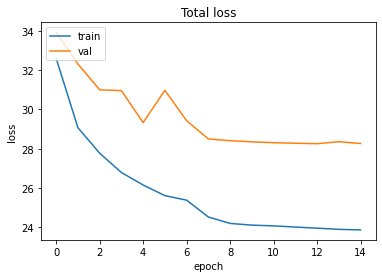

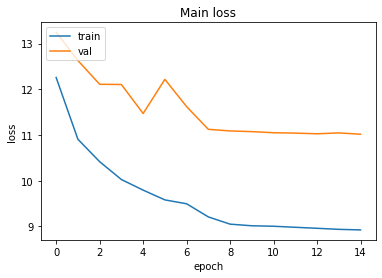

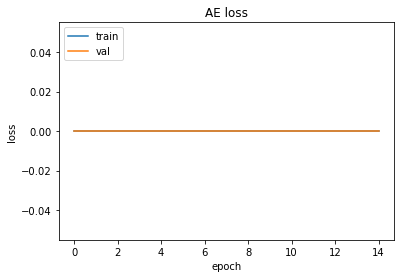

100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.57it/s]


Validation End result: 24.1404, 3.2376, 4.5860, 3.2376


100%|███████████████████████████████████████████| 89/89 [00:03<00:00, 24.74it/s]


External End result: 32.9034, 3.5313, 5.1898, 3.5313
2619 748
EXP #2
cuda:0


100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 28.53it/s]


Train result: 18.0419, 2.8323, 3.9426, 2.8323


100%|███████████████████████████████████████████| 19/19 [00:01<00:00, 18.90it/s]


End result: 28.0335, 3.4031, 4.7700, 3.4031


 61%|████████████████████████▊                | 131/216 [00:06<00:04, 19.10it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:10<00:00, 21.40it/s]


EXP #2
cuda:0
Epoch 0/14
----------
0.001


 74%|██████████████████████████████▏          | 159/216 [00:13<00:04, 13.34it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.72it/s]


train Loss: 32.9099|Main: 12.3442| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.75it/s]


val Loss: 32.2452|Main: 12.6131| AE: 0.0000

Epoch 1/14
----------
0.001


 74%|██████████████████████████████▎          | 160/216 [00:14<00:04, 11.73it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.38it/s]


train Loss: 29.5000|Main: 11.0376| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.54it/s]


val Loss: 30.6343|Main: 12.0107| AE: 0.0000

Epoch 2/14
----------
0.001


 92%|█████████████████████████████████████▊   | 199/216 [00:17<00:01, 12.59it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.47it/s]


train Loss: 28.1533|Main: 10.5363| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 10.89it/s]


val Loss: 29.4725|Main: 11.5576| AE: 0.0000

Epoch 3/14
----------
0.001


 62%|█████████████████████████▏               | 133/216 [00:11<00:07, 11.15it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.40it/s]


train Loss: 27.0078|Main: 10.0797| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.75it/s]


val Loss: 29.5995|Main: 11.6726| AE: 0.0000

Epoch 4/14
----------
0.001


 46%|███████████████████▎                      | 99/216 [00:08<00:09, 12.48it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.32it/s]


train Loss: 26.5894|Main: 9.9286| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 10.91it/s]


val Loss: 28.6863|Main: 11.2801| AE: 0.0000

Epoch 5/14
----------
0.001


 47%|███████████████████▏                     | 101/216 [00:09<00:11, 10.05it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.37it/s]


train Loss: 25.9029|Main: 9.6663| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.56it/s]


val Loss: 30.0474|Main: 11.8516| AE: 0.0000

Epoch 6/14
----------
0.001


 21%|████████▉                                 | 46/216 [00:04<00:12, 13.66it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.53it/s]


train Loss: 25.6424|Main: 9.5632| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.76it/s]


val Loss: 29.4380|Main: 11.5771| AE: 0.0000

Epoch 7/14
----------
0.0001


 15%|██████▍                                   | 33/216 [00:03<00:17, 10.33it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.10it/s]


train Loss: 24.9453|Main: 9.3064| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.57it/s]


val Loss: 27.4406|Main: 10.7740| AE: 0.0000

Epoch 8/14
----------
0.0001


  0%|▏                                          | 1/216 [00:00<01:43,  2.07it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.53it/s]


train Loss: 24.4648|Main: 9.1212| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 10.96it/s]


val Loss: 27.2347|Main: 10.6904| AE: 0.0000

Epoch 9/14
----------
0.0001


 92%|█████████████████████████████████████▌   | 198/216 [00:17<00:01, 11.70it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.27it/s]


train Loss: 24.3532|Main: 9.0822| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.71it/s]


val Loss: 27.1130|Main: 10.6279| AE: 0.0000

Epoch 10/14
----------
0.0001


 40%|████████████████▉                         | 87/216 [00:07<00:11, 11.69it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.25it/s]


train Loss: 24.2763|Main: 9.0417| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.77it/s]


val Loss: 27.1320|Main: 10.6592| AE: 0.0000

Epoch 11/14
----------
0.0001


 72%|█████████████████████████████▍           | 155/216 [00:13<00:05, 11.34it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.27it/s]


train Loss: 24.2176|Main: 9.0298| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 10.83it/s]


val Loss: 26.9617|Main: 10.5672| AE: 0.0000

Epoch 12/14
----------
0.0001


 29%|████████████                              | 62/216 [00:05<00:14, 10.89it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.42it/s]


train Loss: 24.1729|Main: 9.0069| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 10.88it/s]


val Loss: 26.9740|Main: 10.5852| AE: 0.0000

Epoch 13/14
----------
0.0001


 51%|████████████████████▉                    | 110/216 [00:09<00:08, 12.21it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.40it/s]


train Loss: 24.0956|Main: 8.9791| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 10.92it/s]


val Loss: 26.8812|Main: 10.5420| AE: 0.0000

Epoch 14/14
----------
0.0001


 57%|███████████████████████▎                 | 123/216 [00:10<00:07, 12.56it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:18<00:00, 11.44it/s]


train Loss: 24.0595|Main: 8.9697| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.07it/s]


val Loss: 26.9169|Main: 10.5632| AE: 0.0000

Training complete in 5m 60s


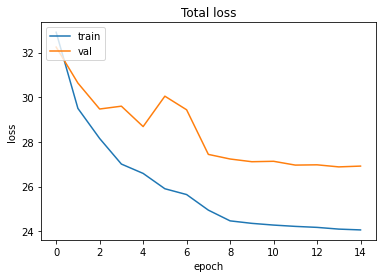

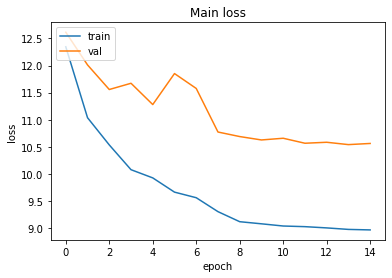

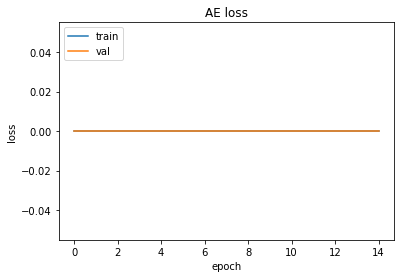

100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.43it/s]


Validation End result: 20.4495, 2.9916, 4.2460, 2.9916


100%|███████████████████████████████████████████| 89/89 [00:03<00:00, 25.01it/s]


External End result: 32.7878, 3.5097, 5.1730, 3.5097
2721 646
EXP #3
cuda:0


100%|███████████████████████████████████████████| 77/77 [00:02<00:00, 28.21it/s]


Train result: 19.5128, 2.8630, 3.9741, 2.8630


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.53it/s]


End result: 33.8220, 3.7285, 5.0906, 3.7285


100%|█████████████████████████████████████████| 216/216 [00:10<00:00, 21.24it/s]


EXP #3
cuda:0
Epoch 0/14
----------
0.001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.36it/s]


train Loss: 32.9273|Main: 12.3417| AE: 0.0000
0.001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 11.02it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.62it/s]


val Loss: 30.1005|Main: 11.8400| AE: 0.0000

Epoch 1/14
----------
0.001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.04it/s]


train Loss: 29.5165|Main: 11.0343| AE: 0.0000
0.001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 10.59it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.32it/s]


val Loss: 28.5652|Main: 11.2282| AE: 0.0000

Epoch 2/14
----------
0.001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.13it/s]


train Loss: 28.0687|Main: 10.4883| AE: 0.0000
0.001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 10.51it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.36it/s]


val Loss: 28.0983|Main: 11.0279| AE: 0.0000

Epoch 3/14
----------
0.001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.12it/s]


train Loss: 27.0970|Main: 10.1099| AE: 0.0000
0.001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 11.24it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.63it/s]


val Loss: 27.3731|Main: 10.7883| AE: 0.0000

Epoch 4/14
----------
0.001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.14it/s]


train Loss: 26.5169|Main: 9.8969| AE: 0.0000
0.001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 11.26it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.64it/s]


val Loss: 26.8590|Main: 10.5218| AE: 0.0000

Epoch 5/14
----------
0.001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.02it/s]


train Loss: 25.9826|Main: 9.6818| AE: 0.0000
0.001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 10.69it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.46it/s]


val Loss: 26.8282|Main: 10.5014| AE: 0.0000

Epoch 6/14
----------
0.001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.06it/s]


train Loss: 25.5111|Main: 9.5048| AE: 0.0000
0.001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 11.18it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.66it/s]


val Loss: 27.3378|Main: 10.6588| AE: 0.0000

Epoch 7/14
----------
0.0001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.94it/s]


train Loss: 24.7734|Main: 9.2169| AE: 0.0000
0.0001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 11.25it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.69it/s]


val Loss: 26.3061|Main: 10.3097| AE: 0.0000

Epoch 8/14
----------
0.0001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.93it/s]


train Loss: 24.4962|Main: 9.1237| AE: 0.0000
0.0001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 11.26it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.55it/s]


val Loss: 26.2153|Main: 10.2834| AE: 0.0000

Epoch 9/14
----------
0.0001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.07it/s]


train Loss: 24.4276|Main: 9.1135| AE: 0.0000
0.0001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 11.03it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.45it/s]


val Loss: 26.1061|Main: 10.2226| AE: 0.0000

Epoch 10/14
----------
0.0001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.13it/s]


train Loss: 24.3350|Main: 9.0636| AE: 0.0000
0.0001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 10.21it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.15it/s]


val Loss: 26.0625|Main: 10.2276| AE: 0.0000

Epoch 11/14
----------
0.0001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.15it/s]


train Loss: 24.3064|Main: 9.0633| AE: 0.0000
0.0001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 10.90it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.55it/s]


val Loss: 26.0468|Main: 10.1877| AE: 0.0000

Epoch 12/14
----------
0.0001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.08it/s]


train Loss: 24.2630|Main: 9.0420| AE: 0.0000
0.0001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 10.41it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.01it/s]


val Loss: 25.9352|Main: 10.1564| AE: 0.0000

Epoch 13/14
----------
0.0001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.16it/s]


train Loss: 24.1960|Main: 9.0184| AE: 0.0000
0.0001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 11.38it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.41it/s]


val Loss: 25.8609|Main: 10.1256| AE: 0.0000

Epoch 14/14
----------
0.0001


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.11it/s]


train Loss: 24.1319|Main: 8.9946| AE: 0.0000
0.0001


 31%|█████████████▌                             | 17/54 [00:02<00:03, 11.21it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.78it/s]


val Loss: 25.8963|Main: 10.1232| AE: 0.0000

Training complete in 6m 3s


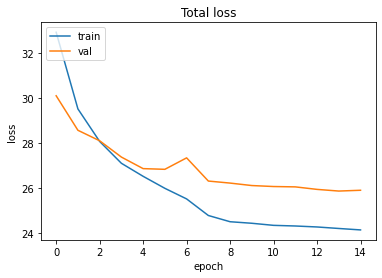

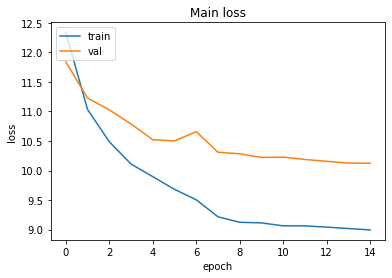

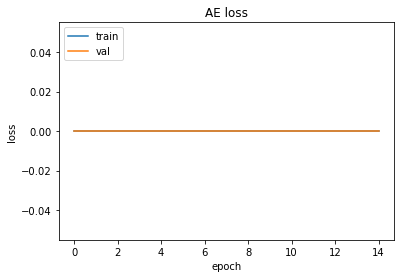

 31%|█████████████▌                             | 17/54 [00:02<00:03, 10.42it/s]

expected string or bytes-like object
nan


100%|███████████████████████████████████████████| 54/54 [00:05<00:00, 10.67it/s]


Validation End result: 23.0053, 3.1992, 4.4731, 3.1992


100%|███████████████████████████████████████████| 89/89 [00:03<00:00, 24.03it/s]


External End result: 32.0868, 3.4434, 5.1150, 3.4434
2777 590
EXP #4
cuda:0


100%|███████████████████████████████████████████| 78/78 [00:02<00:00, 28.72it/s]


Train result: 18.2148, 2.8426, 3.9589, 2.8426


100%|███████████████████████████████████████████| 19/19 [00:01<00:00, 18.72it/s]


End result: 39.4619, 4.0663, 5.4570, 4.0663


 57%|███████████████████████▌                 | 124/216 [00:06<00:04, 22.73it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:10<00:00, 20.07it/s]


EXP #4
cuda:0
Epoch 0/14
----------
0.001


 15%|██████▍                                   | 33/216 [00:03<00:15, 11.45it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.20it/s]


train Loss: 34.8588|Main: 13.0876| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 13.05it/s]


val Loss: 28.0262|Main: 10.9832| AE: 0.0000

Epoch 1/14
----------
0.001


 27%|███████████▍                              | 59/216 [00:06<00:16,  9.74it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.95it/s]


train Loss: 30.5557|Main: 11.4527| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.42it/s]


val Loss: 26.5407|Main: 10.3734| AE: 0.0000

Epoch 2/14
----------
0.001


 23%|█████████▋                                | 50/216 [00:05<00:15, 10.83it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.87it/s]


train Loss: 29.3477|Main: 10.9906| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.50it/s]


val Loss: 25.7139|Main: 10.0749| AE: 0.0000

Epoch 3/14
----------
0.001


  1%|▌                                          | 3/216 [00:00<00:39,  5.43it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 11.00it/s]


train Loss: 28.1423|Main: 10.5243| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.65it/s]


val Loss: 25.5801|Main: 10.0415| AE: 0.0000

Epoch 4/14
----------
0.001


  0%|                                                   | 0/216 [00:00<?, ?it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:20<00:00, 10.77it/s]


train Loss: 27.2226|Main: 10.1778| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.30it/s]


val Loss: 26.6211|Main: 10.5535| AE: 0.0000

Epoch 5/14
----------
0.001


 23%|█████████▌                                | 49/216 [00:04<00:13, 12.59it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.98it/s]


train Loss: 26.8097|Main: 10.0221| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.57it/s]


val Loss: 24.7504|Main: 9.6695| AE: 0.0000

Epoch 6/14
----------
0.001


 60%|████████████████████████▋                | 130/216 [00:12<00:08, 10.08it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.90it/s]


train Loss: 26.5151|Main: 9.9097| AE: 0.0000
0.001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.35it/s]


val Loss: 24.1600|Main: 9.4337| AE: 0.0000

Epoch 7/14
----------
0.0001


  0%|                                                   | 0/216 [00:00<?, ?it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.94it/s]


train Loss: 25.3336|Main: 9.4587| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.30it/s]


val Loss: 23.9183|Main: 9.3418| AE: 0.0000

Epoch 8/14
----------
0.0001


 48%|███████████████████▋                     | 104/216 [00:09<00:09, 12.01it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.87it/s]


train Loss: 25.1940|Main: 9.4116| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.56it/s]


val Loss: 23.8742|Main: 9.3341| AE: 0.0000

Epoch 9/14
----------
0.0001


 15%|██████▍                                   | 33/216 [00:03<00:16, 11.36it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.95it/s]


train Loss: 25.1028|Main: 9.3806| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.54it/s]


val Loss: 23.8452|Main: 9.3151| AE: 0.0000

Epoch 10/14
----------
0.0001


  0%|                                                   | 0/216 [00:00<?, ?it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.92it/s]


train Loss: 25.0161|Main: 9.3392| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.71it/s]


val Loss: 23.7985|Main: 9.3137| AE: 0.0000

Epoch 11/14
----------
0.0001


 51%|█████████████████████                    | 111/216 [00:10<00:11,  9.08it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.96it/s]


train Loss: 24.9646|Main: 9.3279| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.21it/s]


val Loss: 23.7904|Main: 9.2947| AE: 0.0000

Epoch 12/14
----------
0.0001


 73%|█████████████████████████████▊           | 157/216 [00:14<00:05, 11.62it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.97it/s]


train Loss: 24.8990|Main: 9.2985| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 11.91it/s]


val Loss: 23.7492|Main: 9.2881| AE: 0.0000

Epoch 13/14
----------
0.0001


  1%|▌                                          | 3/216 [00:00<00:47,  4.48it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.93it/s]


train Loss: 24.8582|Main: 9.2864| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.46it/s]


val Loss: 23.7311|Main: 9.2671| AE: 0.0000

Epoch 14/14
----------
0.0001


 49%|████████████████████                     | 106/216 [00:10<00:10, 10.94it/s]

expected string or bytes-like object
nan


100%|█████████████████████████████████████████| 216/216 [00:19<00:00, 10.95it/s]


train Loss: 24.7975|Main: 9.2592| AE: 0.0000
0.0001


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.39it/s]


val Loss: 23.7406|Main: 9.2751| AE: 0.0000

Training complete in 6m 1s


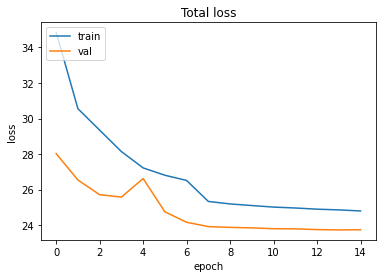

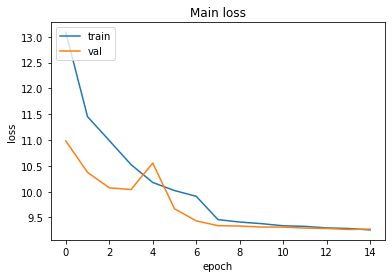

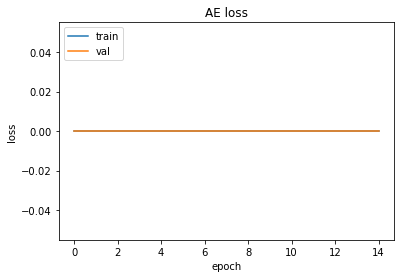

100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 12.34it/s]


Validation End result: 23.3112, 3.2184, 4.4856, 3.2184


100%|███████████████████████████████████████████| 89/89 [00:03<00:00, 25.05it/s]


External End result: 32.9685, 3.4997, 5.1842, 3.4997


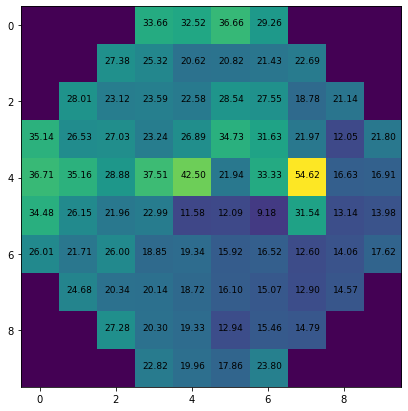

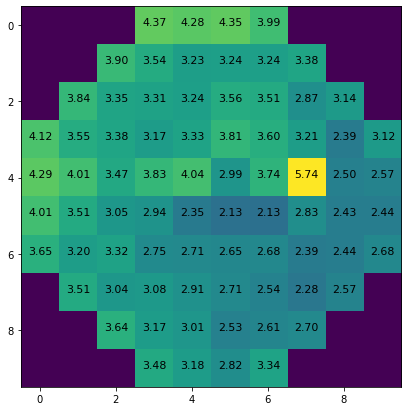

OVERALL: MSE: 22.5926, MAE: 3.1468, RMSE: 4.4370, MAE: 3.1468
External OVERALL: MSE: 32.7489, MAE: 3.4975, RMSE: 5.1688, MAE: 3.4975


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, dataloaders = training_cross_val(df_all, 5, NUM_EPOCHS = 15, training_noise = False)